In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from prophet import Prophet

c:\Users\Tanya\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
df_ltv = pd.read_excel('result_task_2.xlsx', engine='openpyxl')
df_ltv["event_date"] = pd.to_datetime(df_ltv["event_date"])
df_ltv["cohort_date"] = pd.to_datetime(df_ltv["cohort_date"])
df_ltv = df_ltv.sort_values(["cohort_date", "event_date"]).reset_index(drop=True)
cohorts = df_ltv["cohort_date"].unique()

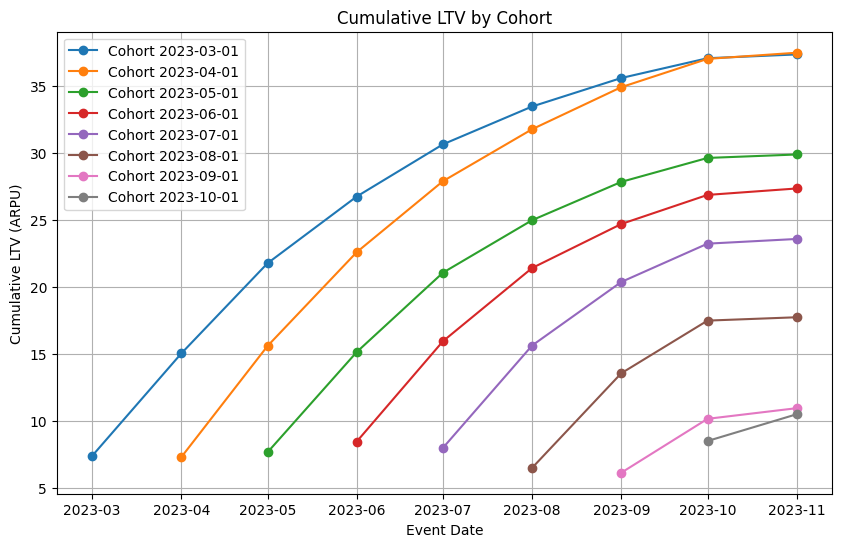

In [3]:
plt.figure(figsize=(10, 6))
for cohort in cohorts:
    subset = df_ltv[df_ltv["cohort_date"] == cohort]
    plt.plot(subset["event_date"], subset["cumulative_ltv"], marker="o", label=f"Cohort {str(cohort)[:10]}")

plt.title("Cumulative LTV by Cohort")
plt.xlabel("Event Date")
plt.ylabel("Cumulative LTV (ARPU)")
plt.legend()
plt.grid(True)

In [4]:
def months_diff(d1, d2):
    rd = relativedelta(d1, d2)
    return rd.years * 12 + rd.months

df_ltv["age"] = df_ltv.apply(lambda row: months_diff(row["event_date"], row["cohort_date"]), axis=1)
df_ltv.head()

,cohort_date,event_date,revenue_usd,cohort_user_count,arpu,cumulative_ltv,age
0,2023-03-01,2023-03-01,5413.95897,734,7.375966,7.375966,0
1,2023-03-01,2023-04-01,5613.42133,734,7.647713,15.023679,1
2,2023-03-01,2023-05-01,4942.66875,734,6.733881,21.757560,2
3,2023-03-01,2023-06-01,3654.66413,734,4.979106,26.736666,3
4,2023-03-01,2023-07-01,2861.26991,734,3.898188,30.634854,4


In [5]:
df_ltv = df_ltv.rename(columns={"event_date": "ds", "cumulative_ltv": "y"})

In [ ]:
all_results = []

for cohort in cohorts:
    cdf = df_ltv[df_ltv["cohort_date"] == cohort].copy()

    cap_value = cdf["y"].iloc[-1] * 1.03
    cdf["cap"] = cap_value
    cdf["floor"] = 0.0

    model = Prophet(
        growth="logistic",
        changepoint_prior_scale=0.02,  
        seasonality_mode="additive"
    )
    model.fit(cdf)

    future = model.make_future_dataframe(periods=6, freq="M")
    future["cap"] = cap_value
    future["floor"] = 0.0
    forecast = model.predict(future)
    forecast["cohort_date"] = cohort
    all_results.append((cdf, forecast))



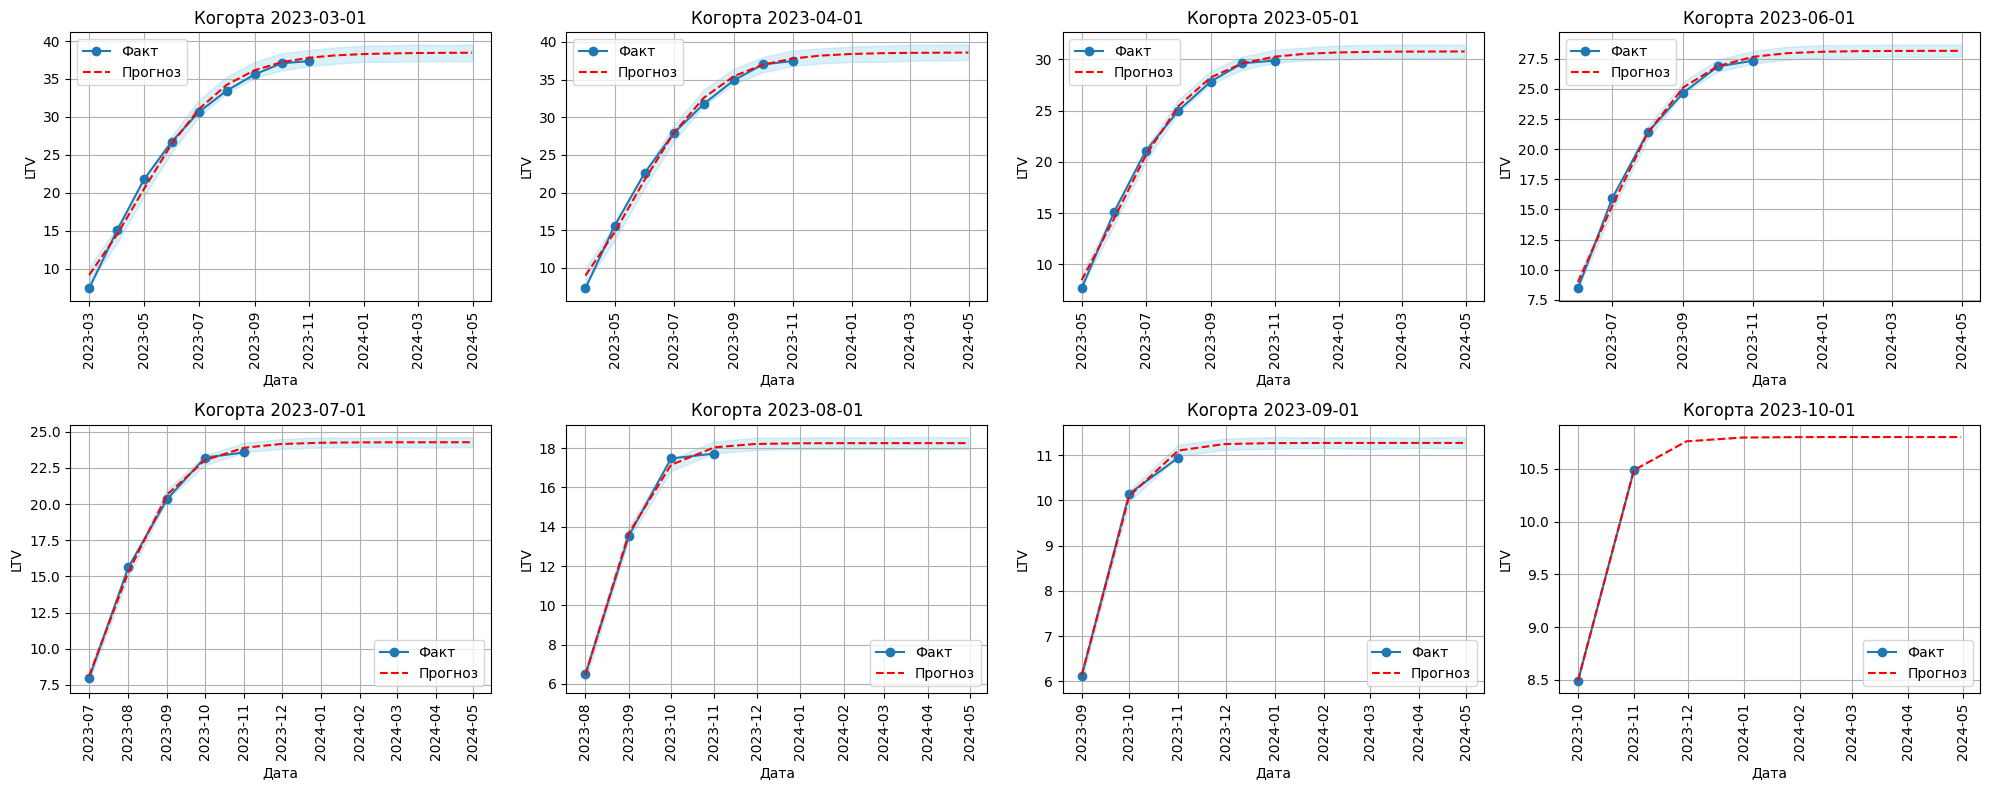

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))  
axes = axes.flatten()

for i, (cdf, forecast) in enumerate(all_results):
    cohort = cdf["cohort_date"].iloc[0].date()
    ax = axes[i]

    ax.plot(cdf["ds"], cdf["y"], "o-", label="Факт")

    ax.plot(forecast["ds"], forecast["yhat"], "r--", label="Прогноз")

    ax.fill_between(
        forecast["ds"],
        forecast["yhat_lower"],
        forecast["yhat_upper"],
        color="skyblue",
        alpha=0.3
    )

    ax.set_title(f"Когорта {cohort}")
    ax.set_xlabel("Дата")
    ax.set_ylabel("LTV")
    ax.grid(True)
    ax.legend()
    ax.tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()

Опис підходу:

Prophet — це підхід до прогнозування часових рядів, створений компанією Meta. 

Адитивна модель часових рядів:

y(t)=g(t)+s(t)+h(t)+ϵt​

g(t) — тренд (лінійний або логістичний з “changepoints”)

s(t) — сезонність (тижнева, річна тощо, через ряди Фур’є)

h(t) — ефекти свят та подій (custom holidays)

ε — шум

Я обрала для прогнозування модель з логістичним насичненням growth="logistic", що досить точно передає тренд LTV, без сезонних коливань

Модель логістичного росту вимагає вказати параметри cap та floor:
cap — верхня межа, до якої може наближатись прогноз,
floor — нижня межа, нижче якої не може впасти прогноз.

Prophet це досить проста і зрозуміла модель для використіння і одночасно вона є досить потужною і дозволяє швидко та гнучко робити прогнози та вносити зміни.

Оцінка підходу:

Цей підхід досить гарно працює зі зрілими когортами, які мають довгу історію.

Питання виникають до прогнозування когорт з декількома точками. Ранні і пізні когорти мают досить суттєві відмінності: березень і квітень показують вищий рівень LTV, тоді як пізніші (липень–серпень) — нижчий, також чим новіша крива тим менше часу їй потрібно щоб вийти на плато.

Тому перед використанням цього підходу потрібно внести деякі зміни:

1. Додати параметри, які впливають на зміну LTV, наприклад на падіння LTV може впливати залучення неякісного трафіку, зміна продукту, зміна до ціноутворення тощо

Це дозволить навчати модель на всіх  когортах і застосовувати її до нових. І усереднена модель не буде завищувати чи спотворюваати тренд

2. Окремо прогнозувати плато, тобто верхню межу для моделі. У мене плато обраховується трохи вище останньої точки, це прийнятно для когорт які затухають, але неправильно описує молоді когорти.

Ми можемо створити модель для обрахунку cap на основі виду підписок користувачів, прогнозованого відтоку, маркетингової стратегії тощо, це дозволить точніше прогнозувати молоді когорти

3. Додати планування не тільки по когортах але і по сегментах. Можна припустити, що різні сегменти користувачів будуть вести себе по різному, тому доцільно прогнозувати окремі сегменти, наприклад за гео, способом залучення,  поведінковою інформацією.

4. Розробити алгоритм для оцінки прогнозування, для того щоб прогноз кумулятивного LTV був валідований.